### Import Library

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load Processed Data

In [9]:
df = pd.read_csv('../data/processed/train_data.csv')
df.head()

,qty,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price,diff_comp_1,ratio_comp_1,diff_comp_2,ratio_comp_2,diff_comp_3,ratio_comp_3,total_cost,product_category_name_computers_accessories,product_category_name_consoles_games,product_category_name_cool_stuff,product_category_name_furniture_decor,product_category_name_garden_tools,product_category_name_health_beauty,product_category_name_perfumery,product_category_name_watches_gifts
0,1,15.100000,45.95,39,161,2,350,4.0,57,23,8,1,5,2017,10.267394,3800,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90,-43.95,0.511123,-169.050000,0.213721,0.0,1.0,61.050000,False,False,False,False,False,False,False,False
1,3,12.933333,45.95,39,161,2,350,4.0,61,22,8,1,6,2017,6.503115,3800,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95,-43.95,0.511123,-163.050000,0.219856,0.0,1.0,58.883333,False,False,False,False,False,False,False,False
2,6,14.840000,45.95,39,161,2,350,4.0,123,21,10,1,7,2017,12.071651,3800,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95,-43.95,0.511123,-159.050000,0.224146,0.0,1.0,60.790000,False,False,False,False,False,False,False,False
3,4,14.287500,45.95,39,161,2,350,4.0,90,23,8,1,8,2017,9.293873,3800,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95,-43.95,0.511123,-153.559804,0.230314,0.0,1.0,60.237500,False,False,False,False,False,False,False,False
4,2,15.100000,45.95,39,161,2,350,4.0,54,21,9,1,9,2017,5.555556,3800,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95,-43.95,0.511123,-117.448710,0.281214,0.0,1.0,61.050000,False,False,False,False,False,False,False,False


### Split Features (X) & Target (y)

In [10]:
# The Target is 'qty' (Demand)
X = df.drop(columns=['qty'])
y = df['qty']

### Train-Test Split (80% Training, 20% Test)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (540, 40)
Testing Data: (136, 40)


### Training Model

In [12]:
print("\nTraining the model...(Please Wait)")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)

# Calculate Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n--- MODEL PERFORMANCE REPORT ---")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Training the model...(Please Wait)

--- MODEL PERFORMANCE REPORT ---
R² Score: 0.6236
MAE: 6.3907
RMSE: 10.1013


### Visualization Reality vs Prediciton

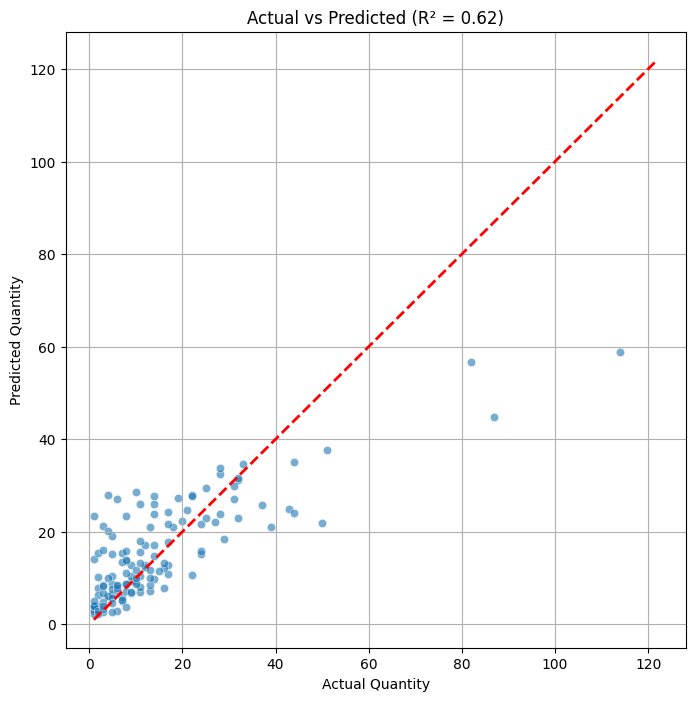

In [13]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Quantity')
plt.ylabel("Predicted Quantity")
plt.title(f'Actual vs Predicted (R² = {r2:.2f})')
plt.grid(True)
plt.show()

## Model Performance Analysis (Post-Leakage Correction)

After removing the data leakage source (`total_price`), we achieved a **realistic** performance baseline:

### 1. Metric Interpretation ($R^2 = 0.62$)
* **Integrity Check:** The drop from 0.95 to 0.62 confirms the removal of the leakage. The previous score was artificially inflated.
* **Business Viability:** An $R^2$ of 0.62 in a noisy retail environment is **acceptable** for an MVP. The model successfully captures 62% of the demand variance driven by price and competition features.

### 2. Visual Diagnosis (Actual vs. Predicted Plot)
Analyzing the scatter plot relative to the identity line (red dashed line):
* **Good Fit on Low-Mid Volume (Qty 0-40):**
    The model performs reliably for standard inventory items, with predictions clustering tightly around the ideal line.
* **Underestimation on High Volume (Qty > 80):**
    The model exhibits **Systematic Negative Bias** on best-sellers.
    * *Observation:* For actual demand of ~115 units, the model predicts ~60-80 units.
    * *Root Cause:* Regression models often revert to the mean and struggle to capture extreme outliers (viral products) without additional external features (e.g., marketing campaigns).

### 3. Strategic Implication
* **Risk:** The model is conservative regarding high-demand items.
* **Impact:** Potential **Opportunity Cost** due to stockouts on best-selling SKUs.
* **Mitigation:** Operational teams should apply a "Safety Stock Multiplier" (e.g., 1.2x) to the model's forecast for top-tier products to cover this conservative bias.

### Save Model

In [14]:
import joblib
import os

os.makedirs('../models', exist_ok=True)
joblib.dump(model, '../models/pricing_model.pkl')
print("Model saved to models/pricing_model.pkl")

Model saved to models/pricing_model.pkl
